# Twist solver

In [1]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt

from math import sqrt
from skimage.data import camera
from pylops.basicoperators import *
from pylops.signalprocessing import *
from pylops.utils.wavelets import *
from pylops.avo.poststack import *
from pylops.optimization.sparsity import *

from pyproximal.proximal import *
from pyproximal.proximal.TV import TV as TVaniso
from pyproximal.optimization.primal import *
from pyproximal.optimization.primaldual import *
from pyproximal.optimization.bregman import *

## 1D Sparsity

To begin we try to compare TWIST with other popular sparsity-promoting solvers in a basic example of compressed sensing (https://pylops.readthedocs.io/en/latest/gallery/plot_ista.html#sphx-glr-gallery-plot-ista-py)

ISTA (soft thresholding)
--------------------------------------------------------------------------------
The Operator Op has 15 rows and 20 cols
eps = 1.000000e-02	tol = 1.000000e-10	niter = 100
alpha = 3.166566e-01	thresh = 1.583283e-03
--------------------------------------------------------------------------------
   Itn          x[0]              r2norm     r12norm     xupdate
     1       1.4957e-01         1.362e+00   1.387e+00   7.213e-01
     2       1.6148e-01         2.991e-01   3.308e-01   2.503e-01
     3       1.5694e-01         1.446e-01   1.786e-01   1.419e-01
     4       1.4977e-01         9.048e-02   1.255e-01   9.754e-02
     5       1.4252e-01         6.371e-02   9.913e-02   7.475e-02
     6       1.3568e-01         4.754e-02   8.313e-02   6.119e-02
     7       1.2934e-01         3.655e-02   7.224e-02   5.182e-02
     8       1.2352e-01         2.859e-02   6.432e-02   4.493e-02
     9       1.1830e-01         2.260e-02   5.844e-02   3.865e-02
    10       1.1374e-

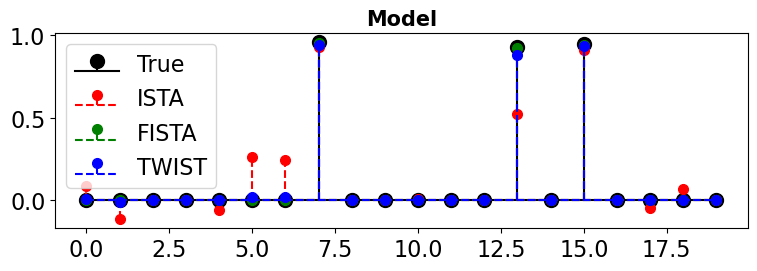

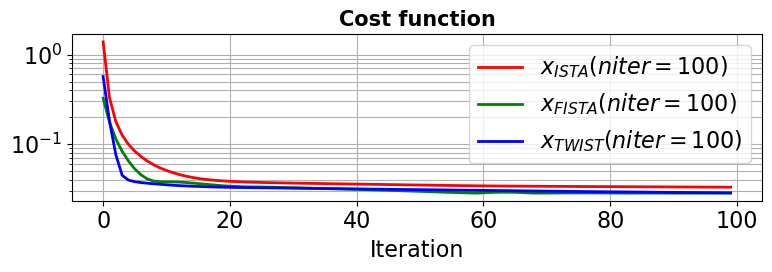

In [2]:
np.random.seed(0)

N, M = 15, 20
A = np.random.randn(N, M)
A = A / np.linalg.norm(A, axis=0)
Aop = MatrixMult(A)

x = np.random.rand(M)
x[x < 0.9] = 0
y = Aop*x

eps = 1e-2
maxit = 100

# ISTA
x_ista, niteri, costi = ista(Aop, y, niter=maxit, eps=eps, tol=1e-10, show=True)
# FISTA
x_fista, niterf, costf = fista(Aop, y, niter=maxit, eps=eps, tol=1e-10, show=True)
# TWIST
l1 = L1(sigma=eps)
eigs = (Aop.H * Aop).eigs()
eigs = (np.abs(eigs[0]), 5e-1)
x_twist, costt = TwIST(l1, Aop, y, eigs=eigs, x0=np.zeros(M), niter=maxit, show=True, returncost=True)

fig, ax = plt.subplots(1, 1, figsize=(8, 3))
m, s, b = ax.stem(x, linefmt='k', basefmt='k',
                  markerfmt='ko', label='True')
plt.setp(m, markersize=10)
m, s, b = ax.stem(x_ista, linefmt='--r', basefmt='--r',
                  markerfmt='ro', label='ISTA')
plt.setp(m, markersize=7)
m, s, b = ax.stem(x_fista, linefmt='--g', basefmt='--g',
                  markerfmt='go', label='FISTA')
plt.setp(m, markersize = 7)
m, s, b = ax.stem(x_twist, linefmt='--b', basefmt='--b',
                  markerfmt='bo', label='TWIST')
plt.setp(m, markersize = 7)
ax.set_title('Model', size=15, fontweight='bold')
ax.legend()
plt.tight_layout()

fig, ax = plt.subplots(1, 1, figsize=(8, 3))
ax.semilogy(costi, 'r', lw=2, label=r'$x_{ISTA} (niter=%d)$' % niteri)
ax.semilogy(costf, 'g', lw=2, label=r'$x_{FISTA} (niter=%d)$' % niterf)
ax.semilogy(costt, 'b', lw=2, label=r'$x_{TWIST} (niter=%d)$' % maxit)
ax.set_title('Cost function', size=15, fontweight='bold')
ax.set_xlabel('Iteration')
ax.legend()
ax.grid(True, which='both')
plt.tight_layout()

## 2D Deblurrring

We try to solve the deconvolution problem:

$$
arg \;  min_\mathbf{u} \frac{\lambda}{2}||\mathbf{Ku-f}||_2^2 + J(\mathbf{u})
$$

where $\mathbf{K}$ is a convolutional operator with a kernel $k$, and different choices of regularization:

- Isotropic TV $ J(\mathbf{u}) = ||\nabla \mathbf{u}||_{2,1}$


Finally we compare the convergence properties of Twist with ISTA and FISTA.

In [3]:
def callback(x):
    mhist.append(x)

Data and operators preparation

In [4]:
# Load image
img = camera().astype(float)
ny, nx = img.shape

In [5]:
# Smoothing operator
nk = 9
k = np.ones((9, 9)) / nk**2
Kop = Convolve2D((ny, nx), k, offset=(nk//2, nk//2))

imgblur = (Kop * img.ravel()).reshape(ny, nx)

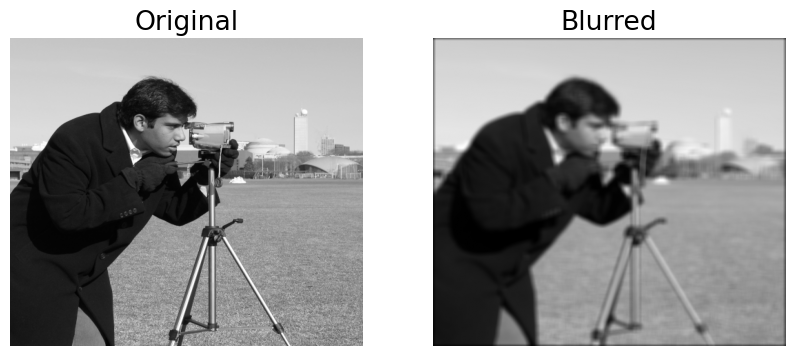

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].imshow(img, cmap='gray')
axs[0].set_title('Original')
axs[0].axis('off')
axs[0].axis('tight')
axs[1].imshow(imgblur, cmap='gray')
axs[1].set_title('Blurred')
axs[1].axis('off')
axs[1].axis('tight');

## Isotropic TV

In [7]:
# L2 data term
lamda = 1.
l2 = L2(Op=Kop, b=imgblur.ravel(), sigma=lamda)

# Isotropic TV
sampling = 1.
sigma = 0.1
Gop = Gradient(dims=(ny, nx), sampling=sampling, edge=False, 
               kind='forward', dtype='float64')
l1iso = L21(ndim=2, sigma=sigma)

# Primal-dual
L =  8. / sampling**2 # maxeig(Grad^H Grad)
tau = 1 / np.sqrt(L)
mu = 1. / (tau*L)

imtv = PrimalDual(l2, l1iso, Gop, tau=tau, mu=mu, theta=1., 
                  x0=np.zeros_like(img.ravel()), gfirst=False,
                  niter=100, show=True)
imtv = imtv.reshape(img.shape)

Primal-dual: min_x f(Ax) + x^T z + g(x)
---------------------------------------------------------
Proximal operator (f): <class 'pyproximal.proximal.L2.L2'>
Proximal operator (g): <class 'pyproximal.proximal.L21.L21'>
Linear operator (A): <class 'pylops.basicoperators.gradient.Gradient'>
Additional vector (z): None
tau = 0.35355339059327373		mu = 0.3535533905932738
theta = 1.00		niter = 100

   Itn       x[0]          f           g          z^x       J = f + g + z^x
     1   1.11078e+01   1.538e+09   1.608e+04   0.000e+00       1.538e+09
     2   2.05927e+01   8.480e+08   2.853e+04   0.000e+00       8.480e+08
     3   2.87140e+01   4.686e+08   3.836e+04   0.000e+00       4.687e+08
     4   3.57185e+01   2.597e+08   4.621e+04   0.000e+00       2.598e+08
     5   4.18038e+01   1.446e+08   5.253e+04   0.000e+00       1.446e+08
     6   4.71283e+01   8.095e+07   5.769e+04   0.000e+00       8.101e+07
     7   5.18194e+01   4.573e+07   6.201e+04   0.000e+00       4.579e+07
     8   5.59810e+

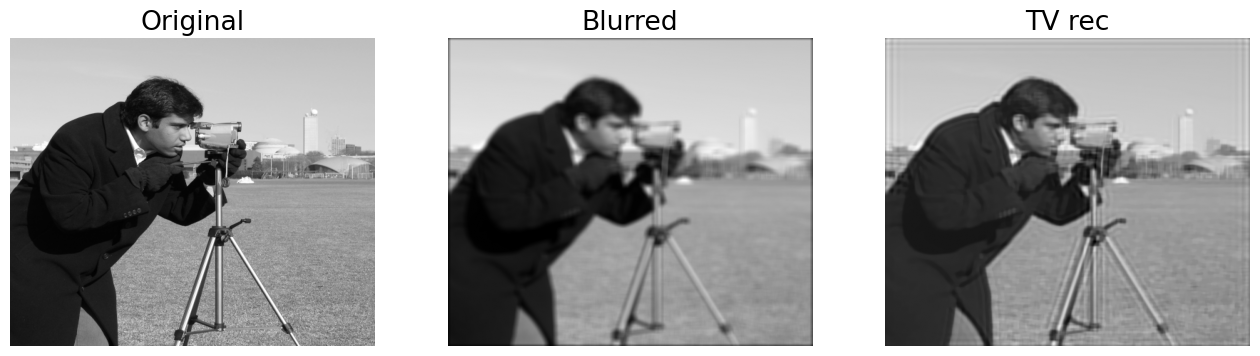

In [8]:
fig, axs = plt.subplots(1, 3, figsize=(16, 4))
axs[0].imshow(img, cmap='gray')
axs[0].set_title('Original')
axs[0].axis('off')
axs[0].axis('tight')
axs[1].imshow(imgblur, cmap='gray')
axs[1].set_title('Blurred')
axs[1].axis('off')
axs[1].axis('tight')
axs[2].imshow(imtv, cmap='gray')
axs[2].set_title('TV rec')
axs[2].axis('off')
axs[2].axis('tight');

In [9]:
emin = 1e-3
emax = 1
k = emin / emax
rho =  (1 - sqrt(k)) / (1 + sqrt(k))
alpha = 1 + rho ** 2
beta = 2 * alpha / (emax + emin)
beta

3.7585310908371135

In [10]:
tv = TVaniso((ny,nx), sigma=sigma)
tv.prox(img.ravel(), 1.).shape, img.ravel().shape

((262144,), (262144,))

In [11]:
imtwist = TwIST(tv, Kop, imgblur.ravel(), alpha=alpha, beta=beta, 
             x0=np.zeros_like(img.ravel()), niter=100, show=True)
imtwist = imtwist.reshape(img.shape)

TwIST
---------------------------------------------------------
Proximal operator (g): <class 'pyproximal.proximal.TV.TV'>
Linear operator (A): <class 'pylops.signalprocessing.convolve2d.Convolve2D'>
alpha = 1.881145e+00	beta = 3.758531e+00	niter = 100

   Itn       x[0]          f           g       J = f + g
     1   1.34079e+02   2.247e+09   1.620e+05   2.247e+09
     2   1.25714e+02   7.422e+09   1.714e+05   7.422e+09
     3   1.49049e+02   1.400e+10   2.266e+05   1.400e+10
     4   1.46789e+02   2.094e+10   2.323e+05   2.094e+10
     5   1.60217e+02   2.755e+10   2.686e+05   2.755e+10
     6   1.60483e+02   3.340e+10   2.702e+05   3.340e+10
     7   1.70407e+02   3.824e+10   2.878e+05   3.824e+10
     8   1.71877e+02   4.200e+10   2.832e+05   4.200e+10
     9   1.80041e+02   4.468e+10   2.890e+05   4.468e+10
    10   1.82435e+02   4.635e+10   2.805e+05   4.635e+10
    11   1.89512e+02   4.711e+10   2.801e+05   4.711e+10
    21   2.12351e+02   2.913e+10   2.088e+05   2.913e+10
    3

# Wavelet sparsity

In [12]:
# L2 data term
lamda = 1.
Qop = DWT2D(img.shape, wavelet='haar', level=2)
l2 = L2(Op=Kop*Qop, b=imgblur.ravel(), sigma=lamda, niter=20)

# L1 Norm of Wavelet
sigma = 0.1
l1 = L1(sigma=sigma)

Accelerated Proximal Gradient
---------------------------------------------------------
Proximal operator (f): <class 'pyproximal.proximal.L2.L2'>
Proximal operator (g): <class 'pyproximal.proximal.L1.L1'>
tau = 1.0	backtrack = False	beta = 5.000000e-01
epsg = 1.0	niter = 100	tol = None
niterback = 100	acceleration = None

   Itn       x[0]          f           g       J=f+eps*g       tau
     1   1.30107e+02   1.059e+07   2.832e+06   1.343e+07   1.000e+00
     2   1.60051e+02   3.243e+06   2.874e+06   6.118e+06   1.000e+00
     3   1.77006e+02   1.724e+06   2.884e+06   4.608e+06   1.000e+00
     4   1.88283e+02   1.133e+06   2.889e+06   4.021e+06   1.000e+00
     5   1.96559e+02   8.316e+05   2.891e+06   3.723e+06   1.000e+00
     6   2.03045e+02   6.530e+05   2.893e+06   3.546e+06   1.000e+00
     7   2.08366e+02   5.360e+05   2.894e+06   3.430e+06   1.000e+00
     8   2.12873e+02   4.540e+05   2.894e+06   3.348e+06   1.000e+00
     9   2.16781e+02   3.935e+05   2.895e+06   3.288e+06

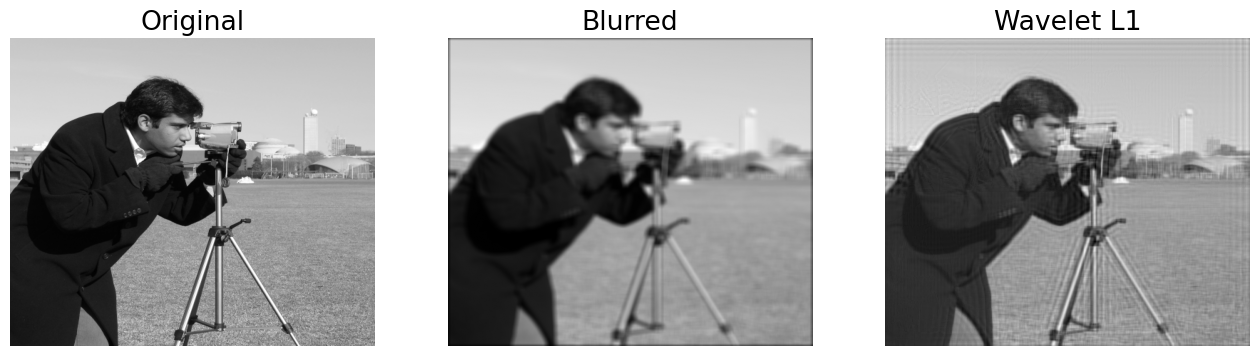

In [13]:
# Proximal gradient
tau = 1.
imq = ProximalGradient(l2, l1, x0=np.zeros_like(img.ravel()), tau=tau, niter=100, show=True)
imq = (Qop*imq).reshape(img.shape)

fig, axs = plt.subplots(1, 3, figsize=(16, 4))
axs[0].imshow(img, cmap='gray')
axs[0].set_title('Original')
axs[0].axis('off')
axs[0].axis('tight')
axs[1].imshow(imgblur, cmap='gray')
axs[1].set_title('Blurred')
axs[1].axis('off')
axs[1].axis('tight')
axs[2].imshow(imq, cmap='gray')
axs[2].set_title('Wavelet L1')
axs[2].axis('off')
axs[2].axis('tight');

1 1.9980019980019983
TwIST
---------------------------------------------------------
Proximal operator (g): <class 'pyproximal.proximal.L1.L1'>
Linear operator (A): <class 'pylops.linearoperator._ProductLinearOperator'>
alpha = 1.000000e+00	beta = 1.998002e+00	niter = 100

   Itn       x[0]          f           g       J = f + g
     1   1.90077e+02   2.681e+06   2.926e+05   2.973e+06
     2   1.98062e+02   1.393e+06   2.874e+05   1.681e+06
     3   2.12496e+02   9.002e+05   2.920e+05   1.192e+06
     4   2.17836e+02   6.561e+05   2.885e+05   9.445e+05
     5   2.25659e+02   5.056e+05   2.918e+05   7.975e+05
     6   2.29523e+02   4.121e+05   2.890e+05   7.011e+05
     7   2.34670e+02   3.418e+05   2.917e+05   6.335e+05
     8   2.37710e+02   2.943e+05   2.894e+05   5.836e+05
     9   2.41380e+02   2.537e+05   2.917e+05   5.454e+05
    10   2.43915e+02   2.257e+05   2.896e+05   5.153e+05
    11   2.46657e+02   1.993e+05   2.917e+05   4.909e+05
    21   2.62794e+02   8.868e+04   2.916e+

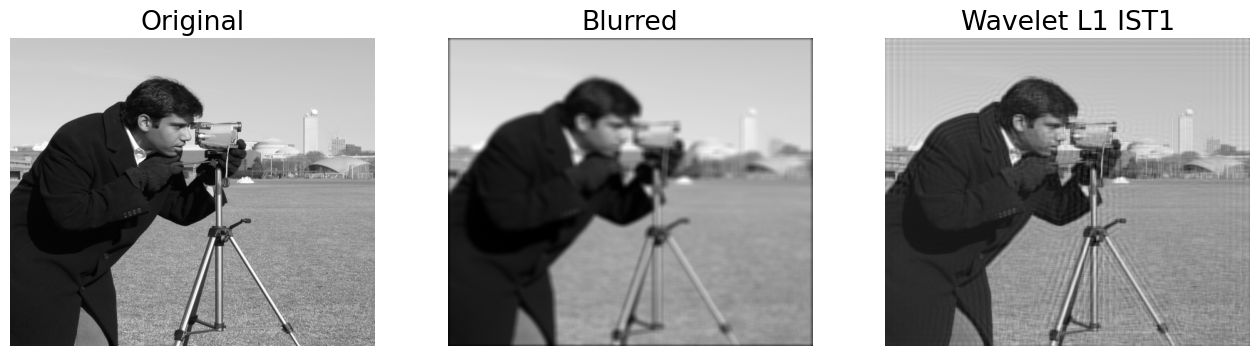

In [14]:
#IST
sigma = 0.01
l1 = L1(sigma=sigma)

alpha = 1
beta = 2 / (emax + emin) # 1
print(alpha, beta)

imist, jist = TwIST(l1, Kop * Qop, imgblur.ravel(), alpha=alpha, beta=beta, 
                    x0=np.zeros_like(img.ravel()), niter=100, show=True, returncost=True)
imist = (Qop*imist).reshape(img.shape)

fig, axs = plt.subplots(1, 3, figsize=(16, 4))
axs[0].imshow(img, cmap='gray')
axs[0].set_title('Original')
axs[0].axis('off')
axs[0].axis('tight')
axs[1].imshow(imgblur, cmap='gray')
axs[1].set_title('Blurred')
axs[1].axis('off')
axs[1].axis('tight')
axs[2].imshow(imist, cmap='gray')
axs[2].set_title('Wavelet L1 IST1')
axs[2].axis('off')
axs[2].axis('tight');

1.0853932672921147 1.6698357958340226
TwIST
---------------------------------------------------------
Proximal operator (g): <class 'pyproximal.proximal.L1.L1'>
Linear operator (A): <class 'pylops.linearoperator._ProductLinearOperator'>
alpha = 1.085393e+00	beta = 1.669836e+00	niter = 100

   Itn       x[0]          f           g       J = f + g
     1   1.91360e+02   2.400e+07   3.151e+05   2.431e+07
     2   1.96088e+02   7.676e+06   2.760e+05   7.952e+06
     3   2.10262e+02   1.753e+06   2.957e+05   2.049e+06
     4   2.15961e+02   5.742e+05   2.880e+05   8.622e+05
     5   2.22722e+02   3.383e+05   2.910e+05   6.293e+05
     6   2.27539e+02   2.665e+05   2.901e+05   5.566e+05
     7   2.31887e+02   2.255e+05   2.905e+05   5.161e+05
     8   2.35546e+02   1.964e+05   2.905e+05   4.869e+05
     9   2.38788e+02   1.736e+05   2.906e+05   4.642e+05
    10   2.41650e+02   1.553e+05   2.906e+05   4.459e+05
    11   2.44219e+02   1.403e+05   2.906e+05   4.309e+05
    21   2.60765e+02   6.

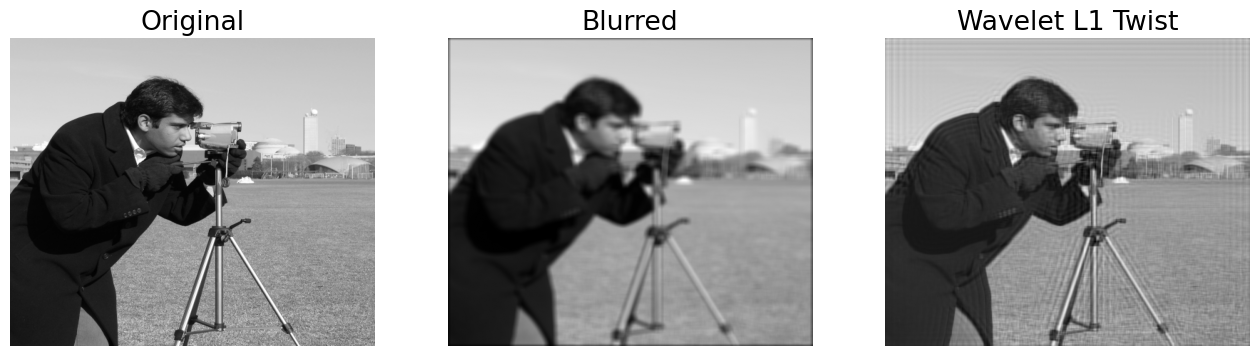

In [15]:
# TWIST
emin = 3e-1
emax = 1
k = emin / emax
rho =  (1 - sqrt(k)) / (1 + sqrt(k))
alpha = 1 + rho ** 2
beta = 2 * alpha / (emax + emin)
print(alpha, beta)

imtwist, jtwist = TwIST(l1, Kop * Qop, imgblur.ravel(), alpha=alpha, beta=beta, 
                        x0=np.zeros_like(img.ravel()), niter=100, show=True, returncost=True)
imtwist = (Qop*imtwist).reshape(img.shape)

fig, axs = plt.subplots(1, 3, figsize=(16, 4))
axs[0].imshow(img, cmap='gray')
axs[0].set_title('Original')
axs[0].axis('off')
axs[0].axis('tight')
axs[1].imshow(imgblur, cmap='gray')
axs[1].set_title('Blurred')
axs[1].axis('off')
axs[1].axis('tight')
axs[2].imshow(imtwist, cmap='gray')
axs[2].set_title('Wavelet L1 Twist')
axs[2].axis('off')
axs[2].axis('tight');

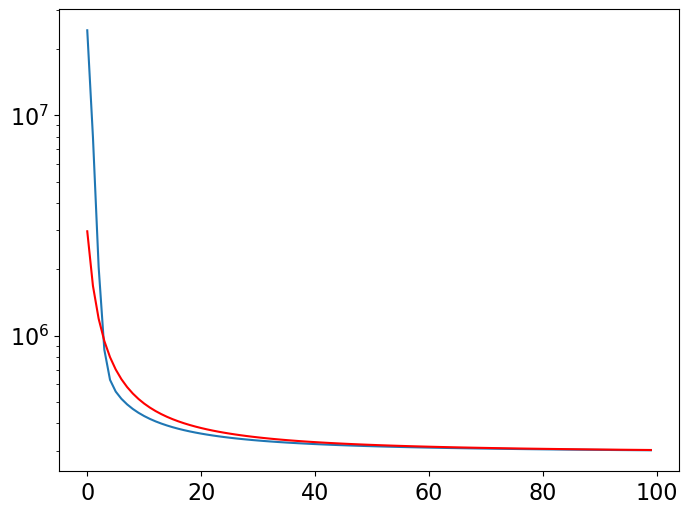

In [16]:
plt.semilogy(jtwist)
plt.semilogy(jist, 'r')